# Problem Statement


> Elo, one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders. 

> Elo has built machine learning models to understand the most important aspects and preferences in their customers’ lifecycle, from food to shopping. But so far none of them is specifically tailored for an individual or profile. 

> We would like to predict the target value based on card_id, which helps ELO to show personalized merchant info, that can promote merchant sales and at the same time customers get only offers what they want to see. 

> This notebook is an attempt to find a signal in the target mystery.







In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"universalastro","key":"cd164d1662a69713780ed3fad4644e8b"}'}

In [ ]:
! chmod 600 /content/kaggle.json


In [ ]:
!kaggle competitions download -c elo-merchant-category-recommendation -p /content

 75% 37.0M/49.4M [00:00<00:00, 46.4MB/s]
100% 49.4M/49.4M [00:00<00:00, 101MB/s] 
  0% 0.00/17.2k [00:00<?, ?B/s]
100% 17.2k/17.2k [00:00<00:00, 16.8MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 203MB/s]
  0% 0.00/1.13M [00:00<?, ?B/s]
100% 1.13M/1.13M [00:00<00:00, 160MB/s]
 71% 9.00M/12.7M [00:00<00:00, 16.8MB/s]
100% 12.7M/12.7M [00:00<00:00, 17.4MB/s]
 97% 531M/548M [00:10<00:00, 86.7MB/s]
100% 548M/548M [00:10<00:00, 54.4MB/s]
  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 13.7MB/s]
  0% 0.00/17.2k [00:00<?, ?B/s]
100% 17.2k/17.2k [00:00<00:00, 18.1MB/s]


In [ ]:
!unzip historical_transactions.csv.zip

Archive:  historical_transactions.csv.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of historical_transactions.csv.zip or
        historical_transactions.csv.zip.zip, and cannot find historical_transactions.csv.zip.ZIP, period.


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  new_merchant_transactions.csv.zip
  inflating: new_merchant_transactions.csv  

Archive:  historical_transactions.csv.zip
  inflating: historical_transactions.csv  

Archive:  merchants.csv.zip
  inflating: merchants.csv           

6 archives were successfully processed.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
train = pd.read_csv('/content/train.csv',parse_dates=['first_active_month'])
test = pd.read_csv('/content/test.csv',parse_dates=['first_active_month'])
mer = pd.read_csv('/content/merchants.csv')
nmt = pd.read_csv('/content/new_merchant_transactions.csv',parse_dates=['purchase_date'])
ht = pd.read_csv('/content/historical_transactions.csv',parse_dates=['purchase_date'])

#take backups , because we will be modifying df as we go
train_back = train.copy()
test_back = test.copy()
ht_back = ht.copy()
nmt_back = nmt.copy()
mer_back = mer.copy()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print("Shape of train set                 : ",train.shape)
print("Shape of test set                  : ",test.shape)
print("Shape of historical_transactions   : ",ht.shape)
print("Shape of merchants                 : ",mer.shape)
print("Shape of new_merchant_transactions : ",nmt.shape)

Shape of train set                 :  (201917, 6)
Shape of test set                  :  (123623, 5)
Shape of historical_transactions   :  (29112361, 14)
Shape of merchants                 :  (334696, 22)
Shape of new_merchant_transactions :  (1963031, 14)


# Train & Test

In [ ]:
train_dic = pd.read_excel('/content/Data_Dictionary.xlsx', sheet_name='train')
train_dic


,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months af...


In [ ]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  201917 non-null  datetime64[ns]
 1   card_id             201917 non-null  object        
 2   feature_1           201917 non-null  int64         
 3   feature_2           201917 non-null  int64         
 4   feature_3           201917 non-null  int64         
 5   target              201917 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  123622 non-null  datetime64[ns]
 1   card_id             123623 non-null  object        
 2   featu

Conclusion: 
* There are no null entries in train/test dataframes. feature_1,feature_2,feature_3 are integers and the column names are anonymous. 
* "Target" column in train set is a continuous variable. 
* Hence this problem is a regression problem.

In [ ]:
print(train.describe())
print(test.describe())

           feature_1      feature_2      feature_3         target
count  201917.000000  201917.000000  201917.000000  201917.000000
mean        3.105311       1.745410       0.565569      -0.393636
std         1.186160       0.751362       0.495683       3.850500
min         1.000000       1.000000       0.000000     -33.219281
25%         2.000000       1.000000       0.000000      -0.883110
50%         3.000000       2.000000       1.000000      -0.023437
75%         4.000000       2.000000       1.000000       0.765453
max         5.000000       3.000000       1.000000      17.965068
          feature_1      feature_2      feature_3
count  123623.00000  123623.000000  123623.000000
mean        3.10926       1.741796       0.564377
std         1.18911       0.749195       0.495840
min         1.00000       1.000000       0.000000
25%         2.00000       1.000000       0.000000
50%         3.00000       2.000000       1.000000
75%         4.00000       2.000000       1.000000
max   

Conclusion: 
* Mean, std, min/max, quantiles are pretty similar between train and test datasets. 
This appears to stratified sampling.

* The split ratio of train and test rows is 100 - ((201917/(123623+201917))*100) is 38% (approx).

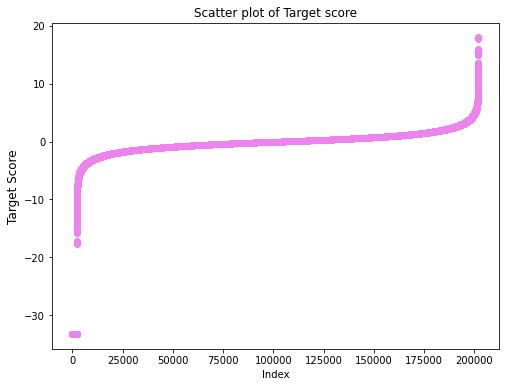

In [ ]:
#Scatter Diagram for target variable from train set
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['target'].values), color="violet")
plt.xlabel('Index', fontsize=10)
plt.ylabel('Target Score', fontsize=12)
plt.title("Scatter plot of Target score")
plt.show()

Conclusion:
* Target values are continuous and we can see some outliers.

In [ ]:
train_10 = train[train['target'] >=10]
train_l10 = train[train['target'] <= -10]
print(train_10['target'].value_counts(bins=10))
print(train_l10['target'].value_counts(bins=10))

(10.13, 10.922]     17
(10.922, 11.704]    10
(11.704, 12.487]     6
(14.835, 15.617]     5
(13.269, 14.052]     5
(17.182, 17.965]     2
(12.487, 13.269]     2
(15.617, 16.4]       1
(16.4, 17.182]       0
(14.052, 14.835]     0
Name: target, dtype: int64
(-33.244, -30.897]    2207
(-12.322, -10.0]        30
(-14.644, -12.322]      16
(-16.966, -14.644]       7
(-19.288, -16.966]       4
(-21.61, -19.288]        0
(-23.932, -21.61]        0
(-26.254, -23.932]       0
(-28.575, -26.254]       0
(-30.897, -28.575]       0
Name: target, dtype: int64


Conclusion:
* Values below -30 seem to be outliers at the first glance. 
* There are 2207 values below -30.
* Values around 14 and 16, too seem to have a break in continuity. This needs further investigation.
* Most values are roughly between -19 and 18.

---



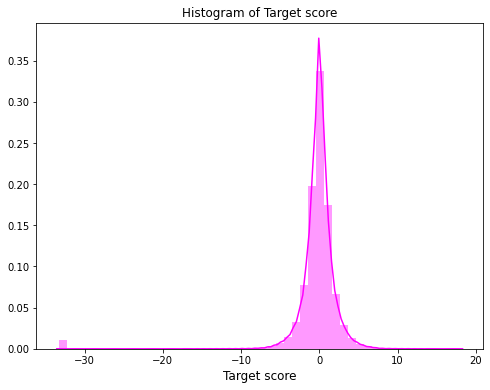

In [ ]:
#Histogram for target variable from train set
plt.figure(figsize=(8,6))
sns.distplot(train['target'].values, bins=50, kde=True, color="magenta")
plt.title("Histogram of Target score")
plt.xlabel('Target score', fontsize=12)
plt.show()

Conclusion: 
* Leaving out the outliers below -30, we can conclude that the target score pretty much follows a normal distribution.

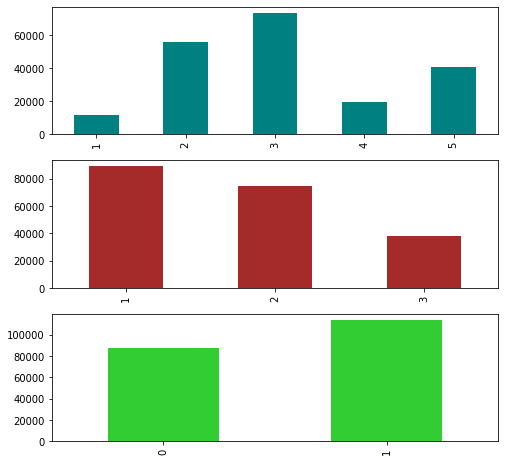

In [ ]:
#Bar plots to show the number of value counts per feature in train set
fig, ax = plt.subplots(3, 1, figsize = (8, 8))
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal')
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown')
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='limegreen');

Conclusion: 
* Feature_1 with value 1 has values below 
20k-- far less than other values, while there is not much difference in other values. 
* Feature_2 and Feature_3 values are more or less within the same range.

In [ ]:
#Looking at Dates ranges
print("Start/End date for train set: ",train['first_active_month'].min() ,train['first_active_month'].max())
print("Start/End date for test set: ",test['first_active_month'].min(),test['first_active_month'].max())


Start/End date for train set:  2011-11-01 00:00:00 2018-02-01 00:00:00
Start/End date for test set:  2011-11-01 00:00:00 2018-01-01 00:00:00


Conclusion: 
* The period of transactions are a little over 7 years timeperiod from 01-11-2011 to 01-02-2018.

2207 outliers found (target < -30)


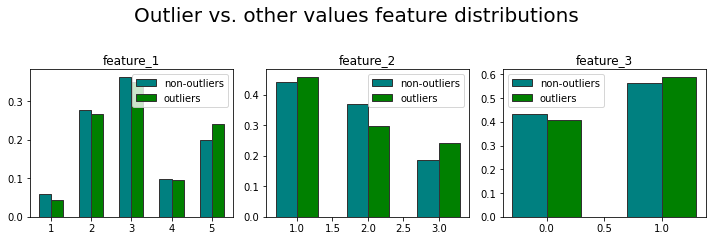

In [ ]:
#Outliers and non-outliers feature distribution
outliers = train.loc[train['target'] < -30]
non_outliers = train.loc[train['target'] >= -30]
print('{:d} outliers found (target < -30)'.format(outliers.shape[0]))

plt.figure(figsize=[10,5])
plt.suptitle('Outlier vs. other values feature distributions', fontsize=20, y=1.1)

for num, col in enumerate(['feature_1', 'feature_2', 'feature_3', 'target']):
  if col is not 'target':
    plt.subplot(2, 3, num+1)
    v_c = non_outliers[col].value_counts() / non_outliers.shape[0]
    plt.bar(v_c.index, v_c, label=('non-outliers'), align='edge', width=-0.3, edgecolor=[0.2]*3, color="teal")
    v_c = outliers[col].value_counts() / outliers.shape[0]
    plt.bar(v_c.index, v_c, label=('outliers'), align='edge', width=0.3, edgecolor=[0.2]*3, color="green")
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

Conclusion: 
* Based on the graphs we cannot single out that a particular feature's value causes outliers.

Correlation Matrix

           feature_1  feature_2  feature_3    target
feature_1   1.000000   0.130969   0.583092  0.014251
feature_2   0.130969   1.000000   0.060925  0.006242
feature_3   0.583092   0.060925   1.000000  0.008125
target      0.014251   0.006242   0.008125  1.000000


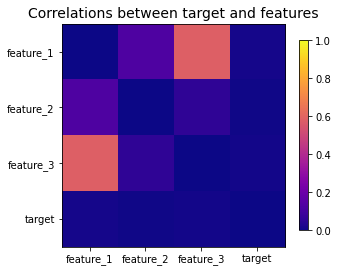

In [ ]:
#correlation matrix
corrs = np.abs(train.corr())
print(corrs)
np.fill_diagonal(corrs.values, 0)
plt.figure(figsize=[5,5])
plt.imshow(corrs, cmap='plasma', vmin=0, vmax=1)
plt.colorbar(shrink=0.7)
plt.xticks(range(corrs.shape[0]), list(corrs.columns))
plt.yticks(range(corrs.shape[0]), list(corrs.columns))
plt.title('Correlations between target and features', fontsize=14)
plt.show()

Conclusion: 
* There seems to be slight correlation between feaure_1 and feature_3, but nothing between target and features. 
* So, use of linear models for modelling is ruled out.

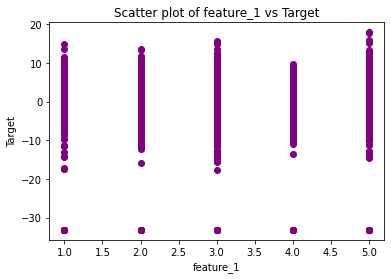

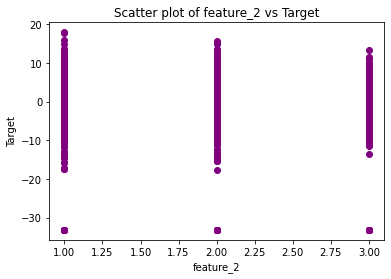

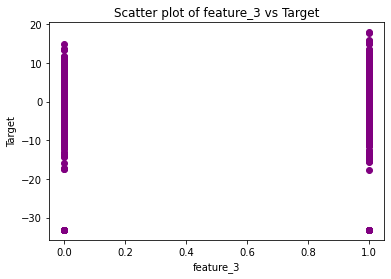

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


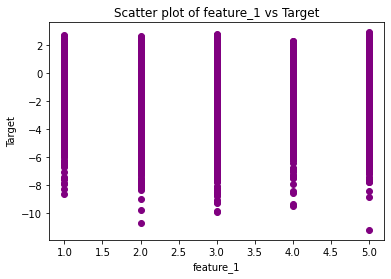

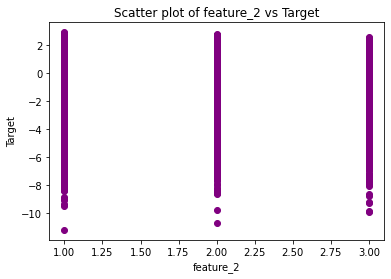

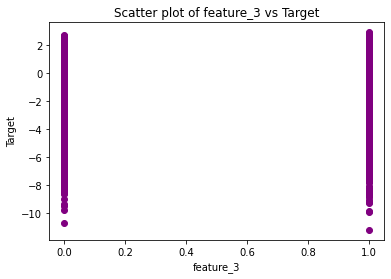

In [87]:
# Scatter plot of features with target
cols = ['feature_1', 'feature_2', 'feature_3']
for feature in cols:
  plt.scatter(train[feature], train['target'],color='purple')
  plt.xlabel(feature)
  plt.ylabel('Target')
  plt.title('Scatter plot of '+feature+" vs Target")
  plt.show()

# Scatter plot of log of features with target
for feature in cols:
  plt.scatter(train[feature], np.log(train['target']), color='purple')
  plt.xlabel(feature)
  plt.ylabel('Target')
  plt.title('Scatter plot of '+feature+" vs Target")
  plt.show()

Conclusion:
* Log of features vs target brought the range from -33-20 to -11 to 3.
* Will this help in modelling and get a lower RMSE ?


# New Merchant Transactions






In [ ]:
new_merchant_dic = pd.read_excel('/content/Data_Dictionary.xlsx', sheet_name='new_merchant_period')
new_merchant_dic

,new_merchant_period.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [ ]:
nmt.info(verbose=2, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   authorized_flag       1963031 non-null  object        
 1   card_id               1963031 non-null  object        
 2   city_id               1963031 non-null  int64         
 3   category_1            1963031 non-null  object        
 4   installments          1963031 non-null  int64         
 5   category_3            1907109 non-null  object        
 6   merchant_category_id  1963031 non-null  int64         
 7   merchant_id           1936815 non-null  object        
 8   month_lag             1963031 non-null  int64         
 9   purchase_amount       1963031 non-null  float64       
 10  purchase_date         1963031 non-null  datetime64[ns]
 11  category_2            1851286 non-null  float64       
 12  state_id              1963031 non-null  in

Min/Max Purchase amount is -0.74689277 and  263.15749789


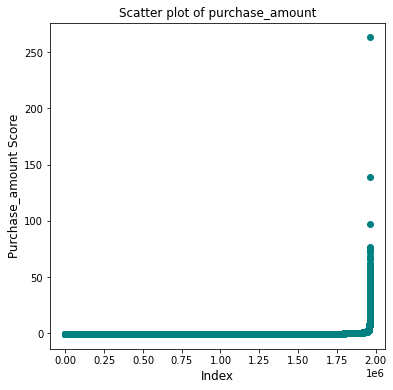

In [ ]:
# Scatter plot for purchase_amount to understand the spread of purchase_amount
print("Min/Max Purchase amount is {} and  {}".format(nmt['purchase_amount'].min(), nmt['purchase_amount'].max()))

plt.figure(figsize=(6,6))
plt.scatter(range(nmt.shape[0]), np.sort(nmt['purchase_amount'].values), color="teal")
plt.xlabel('Index', fontsize=12)
plt.ylabel('Purchase_amount Score', fontsize=12)
plt.title("Scatter plot of purchase_amount")
plt.show()

Conclusion: 
* Purchase amount runs into negative values and highest amount is only 264
* So, it is likely that this data is scaled.

In [ ]:
# We are trying to get rows whose purchase amounts are high
gr_nmt = nmt[nmt['purchase_amount'] >= 80]
print(gr_nmt)

#Let us try to assess the impact on target value of high value transactions
card_ids_gr = gr_nmt['card_id'].values
train_high_amount = train['card_id'].isin(card_ids_gr)
print("High Amount Transactions in train: ",train[train_high_amount].shape[0])
test_high_amount = test['card_id'].isin(card_ids_gr)
print("High Amount Transactions in test: ",test[test_high_amount].shape[0])


        authorized_flag          card_id  ...  state_id subsector_id
228412                Y  C_ID_a289e7edd4  ...        -1           35
893769                Y  C_ID_765f1b0537  ...         9           37
1676431               Y  C_ID_ca850ecf25  ...         9           35

[3 rows x 14 columns]
High Amount Transactions in train:  0
High Amount Transactions in test:  3


Conclusion: 
* The three dots separated from the continuous values of purchase amount seem to be big purchases. 
* We attempted to find a pattern that these big purchases could make on target, but we didn't find these values in train set.



In [ ]:
#Looking at Dates ranges
print("Start/End date for NMT: ",nmt['purchase_date'].min() ,nmt['purchase_date'].max())
print("Start/End date for HT: ",ht['purchase_date'].min(),ht['purchase_date'].max())

Start/End date for NMT:  2017-03-01 03:24:51 2018-04-30 23:59:59
Start/End date for HT:  2017-01-01 00:00:08 2018-02-28 23:59:51


Conclusion: 
* Reference date must be March 01 2018. Transactions that occurred with certain merchants before this date are historical transactions.italicized text

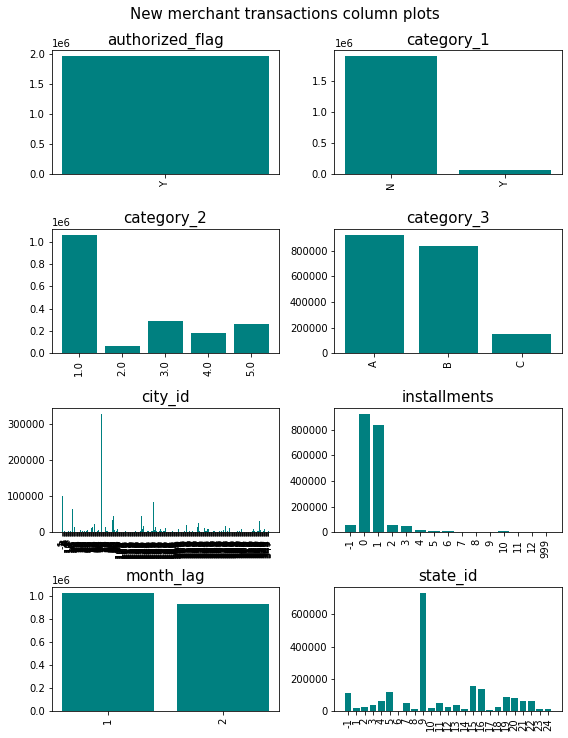

In [77]:
#The idea is show categorical columns value counts as histograms.
#code: https://www.kaggle.com/batalov/making-sense-of-elo-data-eda

category_cols = ['authorized_flag', 'category_1', 'installments','category_3', 'month_lag','category_2','city_id','state_id']

plt.figure(figsize=[8, 10])
plt.suptitle('New merchant transactions column plots', y=1.02, fontsize=15)
ncols = 2
nrows = int(np.ceil((len(category_cols))/2))
last_ind = 0
for col in sorted(list(nmt.columns)):    
    if col in category_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        vc = nmt[col].value_counts()
        x = np.array(vc.index)
        y = vc.values
        inds = np.argsort(x)
        x = x[inds].astype(str)
        y = y[inds]
        plt.bar(x, y, color="teal")
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    
    plt.tight_layout()

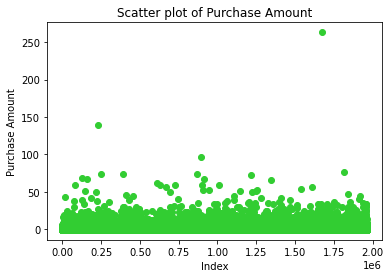

In [82]:
x = nmt.index
y = nmt['purchase_amount']
plt.scatter(x, y, color='limegreen')
plt.xlabel('Index')
plt.ylabel('Purchase Amount')
plt.title("Scatter plot of Purchase Amount")
plt.show()

Conclusion:
* This is another way of looking at outliers -256, 140 and 100.

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


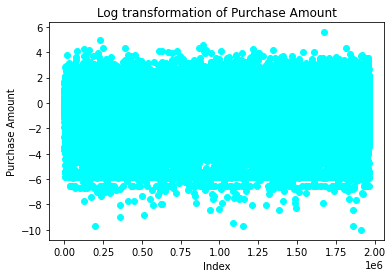

In [81]:
# Purchase amount has some outliers..just to bring all to a single scale.doing log of it
x = nmt.index
y = np.log(nmt['purchase_amount'])
plt.scatter(x, y, color='aqua')
plt.xlabel('Index')
plt.ylabel('Purchase Amount')
plt.title("Log transformation of Purchase Amount")
plt.show()

Conclusion:
* After applying log, all values of purchase amount are in between 6 and -10.
* Might help us when modelling. 



---



1st Quantile:  -0.71662937
Mean:  -0.67484064
3rd Quantile:  -0.58161617
Median:  -0.67484064


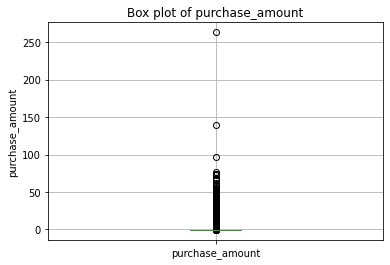

In [100]:
#Box plot of purchase amount
print("1st Quantile: ",nmt['purchase_amount'].quantile(.25))
print("Mean: ",nmt['purchase_amount'].quantile(.5))
print("3rd Quantile: ",nmt['purchase_amount'].quantile(.75))
print("Median: ",nmt['purchase_amount'].median())
cols = ['purchase_amount']
for feature in cols:
  nmt.boxplot(column = feature)  
  plt.ylabel(feature)
  plt.title('Box plot of '+feature)
  plt.show()

Conclusion: 
* There are bunch of outliers outside the box
* Box doesnt even appear in the plot

In [ ]:
# Finding if there any nulls in dataset
nmt.isnull().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

Conclusion: 
* There are no unauthorized transactions. 
* category_1 and category_3 have non-numerical values. 
* There is a month_lag of only 1 or 2 months. 
* Installments have values between -1 and 999. There cannot be -1 installment and 999 installments, which seem to far from the other values (0-12). These could be "errors of omission" or "errors of commission".
* City_id and State_id have negative values, to maintain anonymity, the values have been scaled.
* There are null values in category_2, category_3 and merchant_id.

# Historical Transactions

In [ ]:
history_dic = pd.read_excel('/content/Data_Dictionary.xlsx', sheet_name='history')
history_dic

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


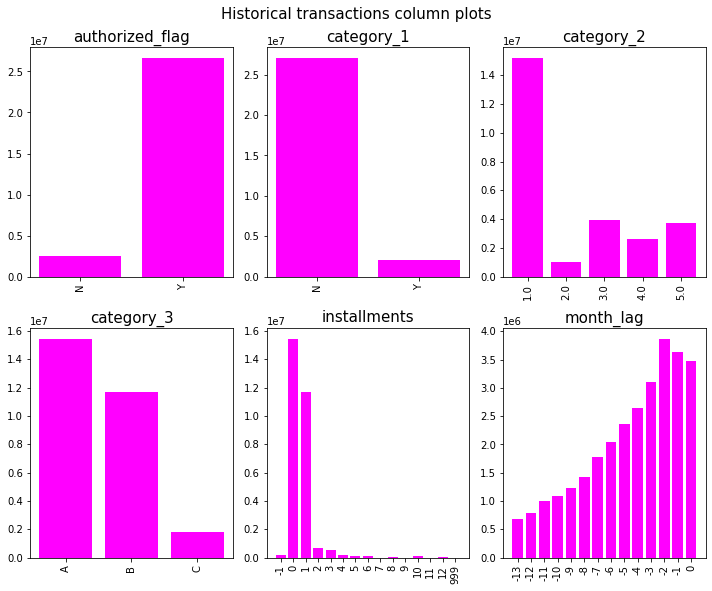

In [ ]:
#The idea is show categorical columns value counts as histograms and numerical columns values as histograms.

#code: https://www.kaggle.com/batalov/making-sense-of-elo-data-eda

category_cols = ['authorized_flag', 'category_1', 'installments','category_3', 'month_lag','category_2']

filtered_ht = ht.loc[ht['purchase_amount'] < 100]

plt.figure(figsize=[10, 8])
plt.suptitle('Historical transactions column plots', y=1.02, fontsize=15)
ncols = 3
nrows = int(np.ceil((len(category_cols)/3)))
last_ind = 0
for col in sorted(list(filtered_ht.columns)):    
    if col in category_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        vc = filtered_ht[col].value_counts()
        x = np.array(vc.index)
        y = vc.values
        inds = np.argsort(x)
        x = x[inds].astype(str)
        y = y[inds]
        plt.bar(x, y, color="magenta")
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    
    plt.tight_layout()

In [ ]:
print("Number of rows with historical installment values as -1 and 999 are {} and {} ".format(ht[ht['installments'] == -1].shape[0], ht[ht['installments'] == 999].shape[0]))
print("Number of rows with new merchant transactions installment values as -1 and 999 are {} and {} ".format(nmt[nmt['installments'] == -1].shape[0], nmt[nmt['installments'] == 999].shape[0]))


Number of rows with historical installment values as -1 and 999 are 178159 and 188 
Number of rows with new merchant transactions installment values as -1 and 999 are 55922 and 2 


Conclusion: 
* Category_1 and category_3 in both transactions dataframes (historical and new merchant) have non-numerical values, we would like to convert to numerical values. We want to run aggregation functions on them like count, sum, mean, median, so it is better to have numerical values.

* There are some unauthorized transactions.  
* Installments have values between -1 and 999. There cannot be -1 installment and 999 installments, which seem to far from the other values (0-12). These could be "errors of omission" or "errors of commission" when collecting data.

* According to the Data_Dictionary.xlsx, loyalty is a numerical score is calculated 2 months after historical and evaluation period. By looking at historical_transactions.csv and new_merchant_transactions.csv, we can find that the historical transactions are the transactions occurred before the "reference date" and new merchant transactions - the ones that occurred after the reference date (according to the 'month_lag' field, which means as "month lag to reference date").

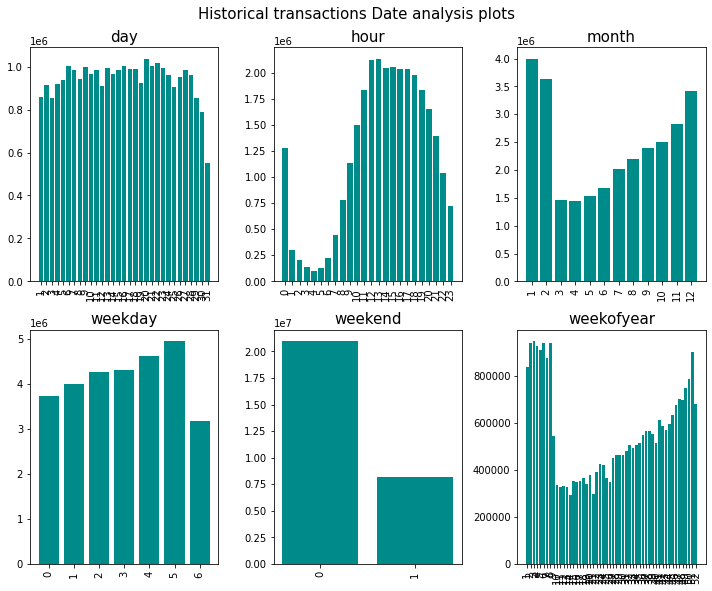

In [88]:
# How were purchases on days/weeks ? Can we find any patterns?
ht['weekofyear'] = ht['purchase_date'].dt.weekofyear
ht['weekday'] = ht['purchase_date'].dt.weekday
ht['weekend'] = (ht['purchase_date'].dt.weekday >=5).astype(int)
ht['month'] = ht['purchase_date'].dt.month
ht['day'] = ht['purchase_date'].dt.day
ht['hour'] = ht['purchase_date'].dt.hour
nmt['weekofyear'] = nmt['purchase_date'].dt.weekofyear
nmt['weekday'] = nmt['purchase_date'].dt.weekday
nmt['weekend'] = (nmt['purchase_date'].dt.weekday >=5).astype(int)
nmt['month'] = nmt['purchase_date'].dt.month
nmt['day'] = nmt['purchase_date'].dt.day
nmt['hour'] = nmt['purchase_date'].dt.hour

#The idea is show categorical columns value counts as histograms and numerical columns values as histograms.

date_cols = ['weekofyear', 'weekday', 'weekend','month', 'day','hour']
plt.figure(figsize=[10, 8])
plt.suptitle('Historical transactions Date analysis plots', y=1.02, fontsize=15)
ncols = 3
nrows = int(np.ceil((len(date_cols)/3)))
last_ind = 0
for col in sorted(list(ht.columns)):    
    if col in date_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        vc = ht[col].value_counts()
        x = np.array(vc.index)
        y = vc.values
        inds = np.argsort(x)
        x = x[inds].astype(str)
        y = y[inds]
        plt.bar(x, y, color="darkcyan")
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    
    plt.tight_layout()

Conclusion:
* Most purchases are on 3rd week of every month -20, 21, 22 dates.
* Most purchases are at noon hours (12, 13 hours).
* Jan, Feb months sees most purchases.
* Friday, Saturday seems to be favorite day for buyers
* Purchases are made more on weekdays compared to weekends


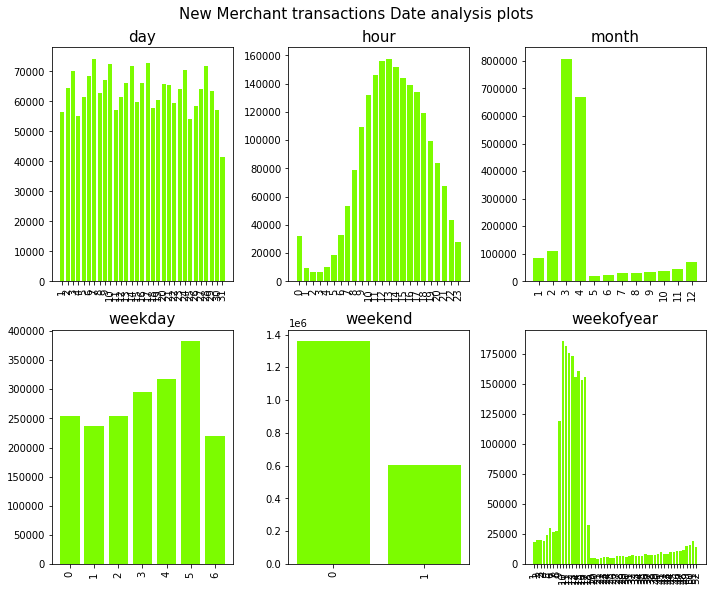

In [ ]:
date_cols = ['weekofyear', 'weekday', 'weekend','month', 'day','hour']
plt.figure(figsize=[10, 8])
plt.suptitle('New Merchant transactions Date analysis plots', y=1.02, fontsize=15)
ncols = 3
nrows = int(np.ceil((len(date_cols)/3)))
last_ind = 0
for col in sorted(list(nmt.columns)):    
    if col in date_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        vc = nmt[col].value_counts()
        x = np.array(vc.index)
        y = vc.values
        inds = np.argsort(x)
        x = x[inds].astype(str)
        y = y[inds]
        plt.bar(x, y, color="lawngreen")
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    
    plt.tight_layout()

Conclusion:
* Afternoon hours are most preferred for shopping. (12,13, 14 hours)
* Shopping on weekdays is preferred.
* Thursday, Friday seems to shoppers favorites
* March, April months are attractive months for shoppers
* Every thursday and friday of every week buyers seem to purchase.

In [ ]:
# Change non-numerical values to numerical and adjust the installment values
def categorize(df):
  for col in ['authorized_flag', 'category_1']:
    df[col] = df[col].map({'Y':1, 'N':0})
  for col in ['installments']:
    df[col] = df[col].map({-1:-1, 0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:9,10:10,11:11,12:12,999:12})
  for col in ['category_3']:
    df[col] = df[col].map({'A':1, 'B':2,'C':3})
  return df

ht = categorize(ht)
nmt = categorize(nmt)

1st Quantile:  -0.72035595
Mean:  -0.68834948
3rd Quantile:  -0.60325434
Median:  -0.68834948
Min purchase_amount:  -0.7469078
Max purchase_amount:  6010603.9717525


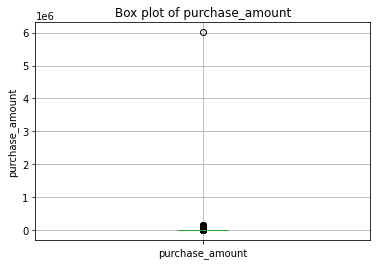

In [103]:
#Box plot and quantiles
print("1st Quantile: ",ht['purchase_amount'].quantile(.25))
print("Mean: ",ht['purchase_amount'].quantile(.5))
print("3rd Quantile: ",ht['purchase_amount'].quantile(.75))
print("Median: ",ht['purchase_amount'].median())
print("Min purchase_amount: ",ht['purchase_amount'].min())
print("Max purchase_amount: ",ht['purchase_amount'].max())
cols = ['purchase_amount']
for feature in cols:
  ht.boxplot(column = feature)  
  plt.ylabel(feature)
  plt.title('Box plot of '+feature)
  plt.show()

Conclusion:
* Presence of outliers is evident that box does not even appear.


# Merchant Information

In [ ]:
mer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int64  
 2   merchant_category_id         334696 non-null  int64  
 3   subsector_id                 334696 non-null  int64  
 4   numerical_1                  334696 non-null  float64
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334683 non-null  float64
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int64  
 12  avg_sales_lag6               334683 non-null  float64
 13 

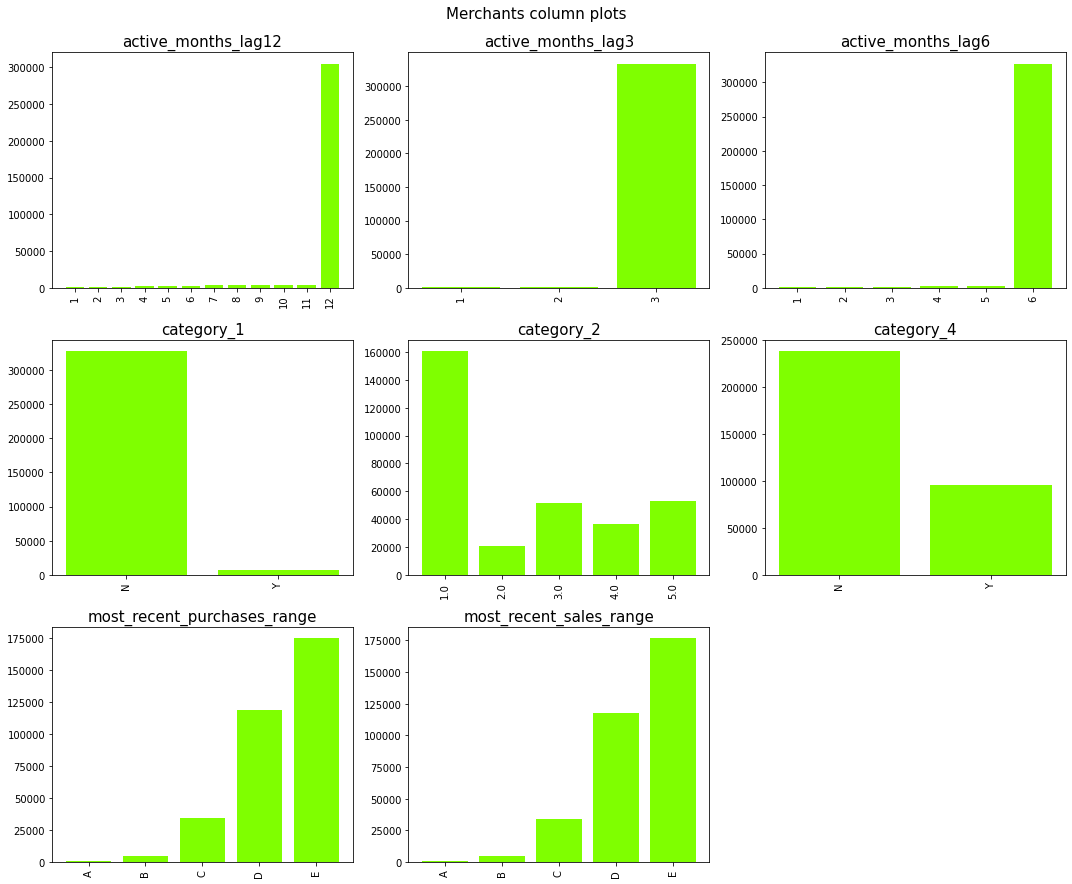

In [ ]:
category_cols = ['most_recent_purchases_range','most_recent_sales_range','active_months_lag12',  'active_months_lag6','category_1','category_2', 'category_4','active_months_lag3','category_4']

plt.figure(figsize=[15, 12])
plt.suptitle('Merchants column plots', y=1.02, fontsize=15)
ncols = 3
nrows = int(np.ceil((len(category_cols) )/3))
last_ind = 0
for col in sorted(list(mer.columns)):    
    if col in category_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        vc = mer[col].value_counts()
        x = np.array(vc.index)
        y = vc.values
        inds = np.argsort(x)
        x = x[inds].astype(str)
        y = y[inds]
        plt.bar(x, y, color='chartreuse')
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    
    plt.tight_layout()

Conclusion:
* most_recent_purchases_range and most_recent_sales_range are high in range E.
* category_ and category_4 is very high in 'N'.
* active_months_lag3,6,12 are very high in their respective 3,6,12.

In [ ]:
# Notice that we are modifying the values to numerical ones so that we can perform aggregate functions on them
mer['most_recent_purchases_range'].replace({'A':4, 'B':3, 'C':2, 'D':1, 'E':0}, inplace=True)
mer['most_recent_sales_range'].replace({'A':4, 'B':3, 'C':2, 'D':1, 'E':0}, inplace=True)
mer['category_1'].replace({'N':0, 'Y':1}, inplace=True)

In [ ]:
# There are so rows that are having infinity values for purchases columns
# Removing them
mer[mer['avg_purchases_lag3'] == np.inf]
mer.drop(mer.index[[10,11,12]], inplace=True)#3 rows only

In [ ]:
#drop 10 null rows of avg_sales
mer.isnull().sum()
indexes = mer[mer['avg_sales_lag3'].isnull()].index
indexes

mer.drop(indexes, inplace=True)
mer.isnull().sum()

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                     0
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                     0
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                    0
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11881
dtype: int64

Conclusion:
* There are just 10 nulls in avg_sales_lag3,6,12
* There are nearly 12k nulls in category_2

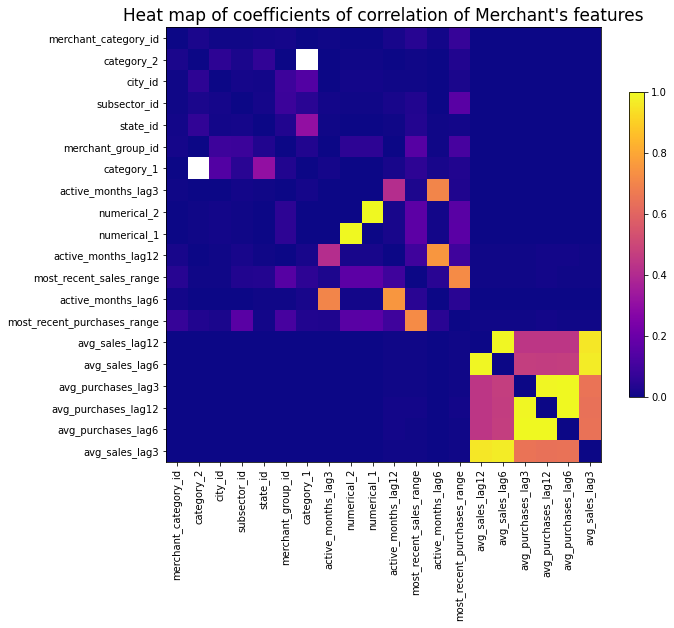

In [ ]:
corrs = np.abs(mer.corr())
ordered_cols = (corrs).sum().sort_values().index
np.fill_diagonal(corrs.values, 0)
plt.figure(figsize=[10,8])
plt.imshow(corrs.loc[ordered_cols, ordered_cols], cmap='plasma', vmin=0, vmax=1)
plt.colorbar(shrink=0.7)
plt.xticks(range(corrs.shape[0]), list(ordered_cols), rotation=90)
plt.yticks(range(corrs.shape[0]), list(ordered_cols))
plt.title('Heat map of coefficients of correlation of Merchant\'s features', fontsize=17)
plt.show()

Conclusion:
* Numerical_1 and Numerical_2 are highly correlated.
* avg_sales_lag3, 6, 12  active_months_lag3, 6, 12 and avg_purchases_lag3, 6, 12 are correlated within itself. Because avg_sales_lag6 is part of avg_sales_lag12, and avg_sales_lag3 part of avg_sales_la6. Same case with above columns as well.
* Most_recent_purchases_range and Most_recent_sales_range  are corelated.

Sales :  [12.06516801 15.74042784 16.18163706]
Purchases :  [1.58675234 1.87610839 2.06224793]
Months:  [ 3.  6. 12.]


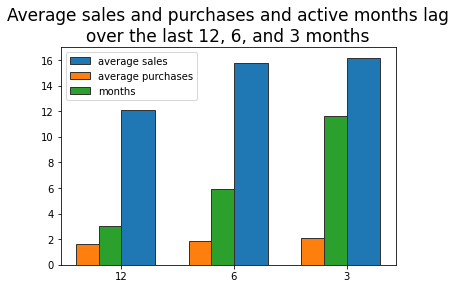

In [ ]:
labels = np.array([12, 6, 3]).astype(str)
sales = mer[['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']].mean().values
purchases = mer[['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']].mean().values
months = mer[['active_months_lag3', 'active_months_lag6', 'active_months_lag12']].mean().values
print("Sales : ",sales)
print("Purchases : ",purchases)
print("Months: ",np.ceil(months))

plt.bar(labels, sales, width=0.3, align='edge', label='average sales', edgecolor=[0.2]*3)
plt.bar(labels, purchases, width=-0.4, align='edge', label='average purchases', edgecolor=[0.2]*3)
plt.bar(labels, months, width=-0.2, align='edge', label='months', edgecolor=[0.2]*3)
plt.legend()
plt.title('Average sales and purchases and active months lag\nover the last 12, 6, and 3 months', fontsize=17)
plt.show()

Conclusion:
* Sales can be seen rising from last 12 months to last 3months
* Purchases is also seen rising to meet the growing demands.
* There is a healthy growth in sales and purchases for merchants. No merchant seems to be affected.
* We have not excluded outliers, even then graph shows positive balance, which is good thing.

Numerical_1 Min Value is -0.05747065 and Max Value is 183.73511137 


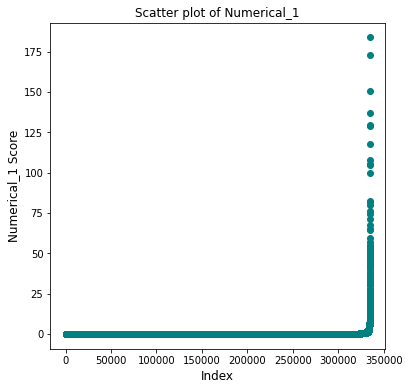

In [ ]:
# Scatter plot for purchase_amount to understand the spread of purchase_amount
print("Numerical_1 Min Value is {} and Max Value is {} ".format(mer['numerical_1'].min(),mer['numerical_1'].max()))
plt.figure(figsize=(6,6))
plt.scatter(range(mer.shape[0]), np.sort(mer['numerical_1'].values), color="teal")
plt.xlabel('Index', fontsize=12)
plt.ylabel('Numerical_1 Score', fontsize=12)
plt.title("Scatter plot of Numerical_1")
plt.show()



Conclusion:
* Values are sparse from 50 onwards. 
* Values from 100 seem like outliers

Numerical_2 Min Value is -0.05747065 and Max Value is 182.07932234 


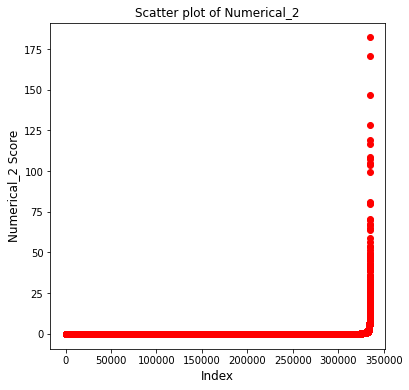

In [ ]:
# Scatter plot for purchase_amount to understand the spread of purchase_amount
print("Numerical_2 Min Value is {} and Max Value is {} ".format(mer['numerical_2'].min(),mer['numerical_2'].max()))
plt.figure(figsize=(6,6))
plt.scatter(range(mer.shape[0]), np.sort(mer['numerical_2'].values), color="red")
plt.xlabel('Index', fontsize=12)
plt.ylabel('Numerical_2 Score', fontsize=12)
plt.title("Scatter plot of Numerical_2")
plt.show()

Conclusion:
* Values are sparse from 60 onwards. 
* Values from 120 seem like outliers
* Min and Max values of numerical_1 and numerical_2 are similar min=-0.05 and max = 182.
* The distributions of numerical_1 and numerical_2 also look similar.

avg_sales_lag12 Min Value is -82.13 and Max Value is 827191.0 
avg_purchases_lag12 Min Value is 0.09832954 and Max Value is 50215.55555556 
avg_sales_lag3 Min Value is -82.13 and Max Value is 851844.64 
avg_purchases_lag3 Min Value is 0.33349533 and Max Value is 61851.33333333 
avg_sales_lag6 Min Value is -82.13 and Max Value is 953792.0 
avg_purchases_lag6 Min Value is 0.16704466 and Max Value is 56077.5 


<Figure size 2592x2592 with 0 Axes>

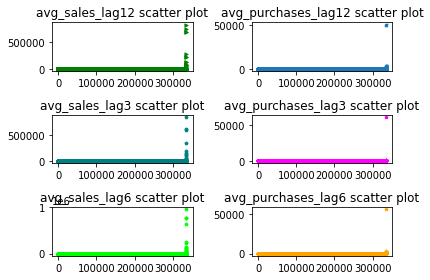

In [ ]:
plt.figure(figsize=(36,36))
fig, axs = plt.subplots(3, 2)
print("avg_sales_lag12 Min Value is {} and Max Value is {} ".format(mer['avg_sales_lag12'].min(),mer['avg_sales_lag12'].max()))
axs[0, 0].scatter(range(mer.shape[0]), np.sort(mer['avg_sales_lag12'].values),  s=10,marker=">", color="green")
axs[0, 0].set_title("avg_sales_lag12 scatter plot")

print("avg_purchases_lag12 Min Value is {} and Max Value is {} ".format(mer['avg_purchases_lag12'].min(),mer['avg_purchases_lag12'].max()))
axs[0, 1].scatter(range(mer.shape[0]), np.sort(mer['avg_purchases_lag12'].values), s=10,  marker=r'$\alpha$')
axs[0, 1].set_title("avg_purchases_lag12 scatter plot")

print("avg_sales_lag3 Min Value is {} and Max Value is {} ".format(mer['avg_sales_lag3'].min(),mer['avg_sales_lag3'].max()))
axs[1, 0].scatter(range(mer.shape[0]), np.sort(mer['avg_sales_lag3'].values), s=10,  marker=(5, 0),color="teal")
axs[1, 0].set_title("avg_sales_lag3 scatter plot")

print("avg_purchases_lag3 Min Value is {} and Max Value is {} ".format(mer['avg_purchases_lag3'].min(),mer['avg_purchases_lag3'].max()))
axs[1, 1].scatter(range(mer.shape[0]), np.sort(mer['avg_purchases_lag3'].values), s=10, marker=(5, 1), color="magenta")
axs[1, 1].set_title("avg_purchases_lag3 scatter plot")

print("avg_sales_lag6 Min Value is {} and Max Value is {} ".format(mer['avg_sales_lag6'].min(),mer['avg_sales_lag6'].max()))
axs[2, 0].scatter(range(mer.shape[0]), np.sort(mer['avg_sales_lag6'].values), s=10,  marker=(5, 0),color="lime")
axs[2, 0].set_title("avg_sales_lag6 scatter plot")

print("avg_purchases_lag6 Min Value is {} and Max Value is {} ".format(mer['avg_purchases_lag6'].min(),mer['avg_purchases_lag6'].max()))
axs[2, 1].scatter(range(mer.shape[0]), np.sort(mer['avg_purchases_lag6'].values), s=10, marker=(5, 1), color="orange")
axs[2, 1].set_title("avg_purchases_lag6 scatter plot")
plt.tight_layout()
plt.show()

Conclusion:
* All the plots show that avg_sales and avg_purchases have outliers.
* Sales and purchases have a big range, where min is in negative value and max has value in lakhs. Is the data really scaled ?